In [1]:
import GMesh
import math
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read topo data
!cp -n /archive/gold/datasets/topography/GEBCO_08_v2.nc .
with netCDF4.Dataset('GEBCO_08_v2.nc') as nc:
    topo_lon = nc.variables['longitude'][:].filled(0.)
    topo_lat = nc.variables['latitude'][:].filled(0.)
    topo_depth = nc.variables['depth'][:,:].filled(0.)

In [3]:
print(topo_lon.min(), topo_lon.max(), topo_lat.min(), topo_lat.max())

-179.99583333333334 179.99583333333334 -89.99583333333334 89.99583333333334


In [4]:
import importlib
importlib.reload(GMesh)

<module 'GMesh' from '/local2/home/GitHub/thin-wall-topography/python/GMesh.py'>

In [5]:
# Read target mesh
with netCDF4.Dataset('/local2/home/GitHub/OM4_025-grid-data/ocean_hgrid.nc') as nc:
    fullG = GMesh.GMesh( lon=nc.variables['x'][::2,::2], lat=nc.variables['y'][::2,::2] )

In [6]:
di, dj = fullG.ni // 6, fullG.nj // 30
print('window size dj,di =',dj,di,'full model nj,ni=',fullG.nj, fullG.ni)
Hcnt = np.zeros((fullG.nj, fullG.ni)) # Diagnostic: counting which cells we are working on
Htarg = np.zeros((fullG.nj, fullG.ni))
gtic = GMesh.GMesh._toc(None,"")
for j in [3]:#range( fullG.nj // dj ):
    csj, sj = slice( j*dj, (j+1)*dj ), slice( j*dj, (j+1)*dj+1 )
    print('sj=',sj,'csj=',csj)
    for i in [4]:#range( fullG.ni // di ):
        csi, si = slice( i*di, (i+1)*di ), slice( i*di, (i+1)*di+1 )
        print('si=',si,'csi=',csi)
        Hcnt[csj,csi] = Hcnt[csj,csi] + 1 # Diagnostic: counting which cells we are working on
        G = GMesh.GMesh( lon = fullG.lon[sj,si], lat = fullG.lat[sj,si] )
        print(j, i, G, G.lon.min(), G.lon.max(), G.lat.min(), G.lat.max())
        # This subsets the source topography so we don't work with too large arrays
        tslices = G.find_source_spanning_slices( topo_lon, topo_lat )
        print('topo slices =', tslices)
        # This recusrively refine the mesh until some criteria is met ...
        levels = G.refine_loop( topo_lon[tslices[0]], topo_lat[tslices[1]], resolution_limit=False, fixed_refine_level=6 )
        # Use nearest neighbor topography to populate the finest grid
        levels[-1].project_source_data_onto_target_mesh( topo_lon[tslices[0]], topo_lat[tslices[1]], topo_depth[tslices[1],tslices[0]] )
        # Now recursively coarsen
        while len( levels) > 1:
            levels[-1].coarsenby2( levels[-2] )
            del levels[-1]
        # Store window in final array
        Htarg[csj,csi] = levels[0].height
GMesh.GMesh._toc(gtic,"Whole workflow")
print( Hcnt.min(), Hcnt.max(), '<-- should both be 1 for full model' )

window size dj,di = 36 240 full model nj,ni= 1080 1440
sj= slice(108, 145, None) csj= slice(108, 144, None)
si= slice(960, 1201, None) csi= slice(960, 1200, None)
3 4 <GMesh nj:36 ni:240 shape:(36,240)> -60.0 0.0 -70.10040622973943 -66.46339347431048
topo slices = (slice(14399, 21600, None), slice(2387, 2825, None))
Refine level 0 <GMesh nj:36 ni:240 shape:(36,240)> Hit 8640 out of 3154038 cells (0.1318 Mb)
Refine level 1 <GMesh nj:72 ni:480 shape:(72,480)> Hit 34560 out of 3154038 cells (0.5273 Mb)
Refine level 2 <GMesh nj:144 ni:960 shape:(144,960)> Hit 138240 out of 3154038 cells (2.1094 Mb)
Refine level 3 <GMesh nj:288 ni:1920 shape:(288,1920)> Hit 552960 out of 3154038 cells (8.4375 Mb)
Refine level 4 <GMesh nj:576 ni:3840 shape:(576,3840)> Hit 1678080 out of 3154038 cells (33.7500 Mb)
Refine level 5 <GMesh nj:1152 ni:7680 shape:(1152,7680)> Hit 3146400 out of 3154038 cells (135.0000 Mb)
Refine level 6 <GMesh nj:2304 ni:15360 shape:(2304,15360)> Hit 3146400 out of 3154038 cells (5

In [7]:
# ax = plt.subplot(111)
# G.plot(ax)

In [8]:
levels = G.refine_loop( topo_lon[tslices[0]], topo_lat[tslices[1]], resolution_limit=False, fixed_refine_level=6, timers=True )

Refine level 0 <GMesh nj:36 ni:240 shape:(36,240)> Hit 8640 out of 3154038 cells (0.1318 Mb)
        16ms : Set up
         3ms : refine by 2
         9ms : calculate hits on topo grid
Refine level 1 <GMesh nj:72 ni:480 shape:(72,480)> Hit 34560 out of 3154038 cells (0.5273 Mb)
         3ms : extending list
        16ms : Total for loop
         6ms : refine by 2
        19ms : calculate hits on topo grid
Refine level 2 <GMesh nj:144 ni:960 shape:(144,960)> Hit 138240 out of 3154038 cells (2.1094 Mb)
         3ms : extending list
        29ms : Total for loop
        26ms : refine by 2
        65ms : calculate hits on topo grid
Refine level 3 <GMesh nj:288 ni:1920 shape:(288,1920)> Hit 552960 out of 3154038 cells (8.4375 Mb)
         3ms : extending list
        94ms : Total for loop
       135ms : refine by 2
       258ms : calculate hits on topo grid
Refine level 4 <GMesh nj:576 ni:3840 shape:(576,3840)> Hit 1678080 out of 3154038 cells (33.7500 Mb)
         3ms : extending list
    

In [9]:
# Use nearest neighbor topography to populate the finest grid
levels[-1].project_source_data_onto_target_mesh( topo_lon[tslices[0]], topo_lat[tslices[1]], topo_depth[tslices[1],tslices[0]], timers=True )

      5524ms : Calculate interpolation indexes
         0ms : Allocate memory
       292ms : indirect indexing
      5817ms : Whole process


In [10]:
# Now recursively coarsen
while len( levels) > 1:
    levels[-1].coarsenby2( levels[-2], timers=True )
    del levels[-1]

        75ms : Whole process
        18ms : Whole process
         4ms : Whole process
         1ms : Whole process
         0ms : Whole process
         0ms : Whole process


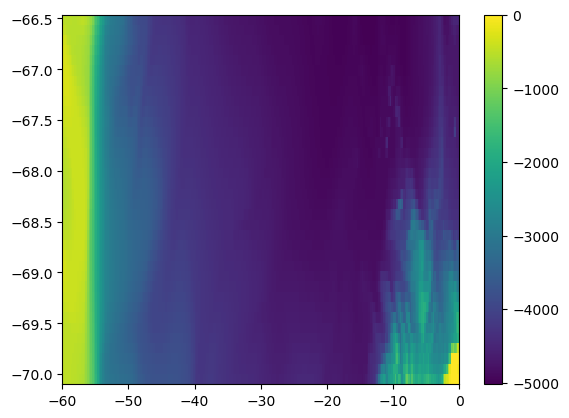

In [11]:
G = levels[0]
plt.pcolormesh( G.lon, G.lat, np.minimum( G.height, 0. ) ); plt.colorbar();

In [12]:
# Read OM4 data
with netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_topog.nc') as nc:
    print(nc)
    OM4_depth = nc.variables['depth'][:,:].filled(0.)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): nEdits(95), ny(1080), nx(1440), ntiles(1)
    variables(dimensions): int32 jEdit(nEdits), float32 depth(ny, nx), float32 h2(ny, nx), int32 iEdit(nEdits), float32 modified_mask(ny, nx), float32 wet(ny, nx), float32 zEdit(nEdits)
    groups: 


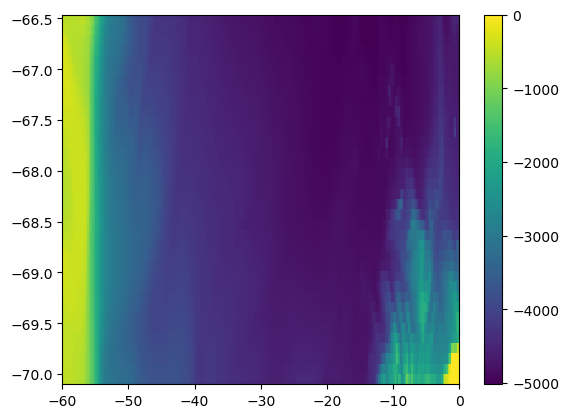

In [13]:
plt.pcolormesh( G.lon, G.lat, -OM4_depth[sj,si][:-1,:-1] ); plt.colorbar();

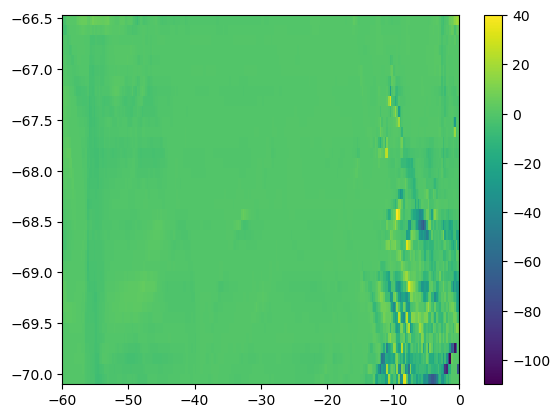

In [14]:
plt.pcolormesh( G.lon, G.lat, np.minimum( G.height, 0. ) + OM4_depth[sj,si][:-1,:-1] ); plt.colorbar();